# Импорты и глобальные переменные

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm.auto import tqdm

import metrics
from preprocessing import text_preprocessing

In [2]:
TRAIN_DATA_PATH = r'data/input/train.parquet'
TEST_DATA_PATH = r'data/input/test.parquet'
OUTPUT_FOLDER_PATH = r'data/output'

In [3]:
data_train = pd.read_parquet(TRAIN_DATA_PATH, engine="pyarrow")
data_test = pd.read_parquet(TEST_DATA_PATH, engine="pyarrow")

In [4]:
def read_random_titles_and_descriptions(data, n=3):
    data = data.sample(n=n)
    texts = list(zip(data.title, data.description))
    for text in texts:
        title = text[0]
        description = text[1]
        print('-'*100)
        print(f'title: \n{title},\ndescription: \n{description}')

In [5]:
read_random_titles_and_descriptions(data_train)

----------------------------------------------------------------------------------------------------
title: 
Фильтр масляный мото mann MW64,
description: 
MANN MW64 новые в упаковке
----------------------------------------------------------------------------------------------------
title: 
Запчасть для мясорубки Philips,
description: 
# запчасти для мясорубки #
Втулка шнека для мясорубок Philips HR2708, HR2710, HR2721, HR2713, HR2722, HR2723
----------------------------------------------------------------------------------------------------
title: 
Ботинки для девочки новые 31 р,
description: 
Ботинки новые. Переросли.


# Токенизация


In [6]:
tokenized_texts, targets = text_preprocessing.get_enhanced_texts(
    data_train,
    test=False,
    keep_stopwords=False,  # Удаляем стоп-слова
)


Processing 312908 texts...
  Processed 10000/312908
  Processed 20000/312908
  Processed 30000/312908
  Processed 40000/312908
  Processed 50000/312908
  Processed 60000/312908
  Processed 70000/312908
  Processed 80000/312908
  Processed 90000/312908
  Processed 100000/312908
  Processed 110000/312908
  Processed 120000/312908
  Processed 130000/312908
  Processed 140000/312908
  Processed 150000/312908
  Processed 160000/312908
  Processed 170000/312908
  Processed 180000/312908
  Processed 190000/312908
  Processed 200000/312908
  Processed 210000/312908
  Processed 220000/312908
  Processed 230000/312908
  Processed 240000/312908
  Processed 250000/312908
  Processed 260000/312908
  Processed 270000/312908
  Processed 280000/312908
  Processed 290000/312908
  Processed 300000/312908
  Processed 310000/312908


In [7]:
X_train, X_val, y_train, y_val = train_test_split(tokenized_texts, targets, test_size=0.2)

# LSA + LINEAR MODELS

In [8]:
tfidf_vectorizer = TfidfVectorizer(
    analyzer=lambda x: x,
    lowercase=False,
    token_pattern=None,
    min_df=5,
    max_df=0.1
)


tfidf_vectorizer.fit(X_train)
tfidf_corps_train = tfidf_vectorizer.transform(X_train)
tfidf_corps_val = tfidf_vectorizer.transform(X_val)

In [9]:
truncated_svd_corps = TruncatedSVD(n_components=100, algorithm='randomized', random_state=42)
lsa_corps_train = truncated_svd_corps.fit_transform(tfidf_corps_train)
lsa_corps_val = truncated_svd_corps.transform(tfidf_corps_val)


In [10]:
param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
    "max_iter": [1500, 3000],
    "tol": [1e-4],
    "selection": ["cyclic", "random"]
}

lsa_lasso = GridSearchCV(
    Lasso(),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

lsa_lasso.fit(lsa_corps_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,Lasso()
,param_grid,"{'alpha': [0.001, 0.01, ...], 'max_iter': [1500, 3000], 'selection': ['cyclic', 'random'], 'tol': [0.0001]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.001


In [11]:
lsa_lasso_preds = lsa_lasso.predict(lsa_corps_val)
lsa_lasso_preds = np.maximum(0, lsa_lasso_preds)
print(f'log mae macro: {metrics.logmae_macro(y_val, lsa_lasso_preds)}')
print(f'log mae by cats: {metrics.logmae_bycat(y_val, lsa_lasso_preds)}')


log mae macro: 0.4463326689902789
log mae by cats: [0.51331594 0.57152284 0.3500203  0.3504716 ]


[Text(0, 0, 'true'), Text(1, 0, 'pred')]

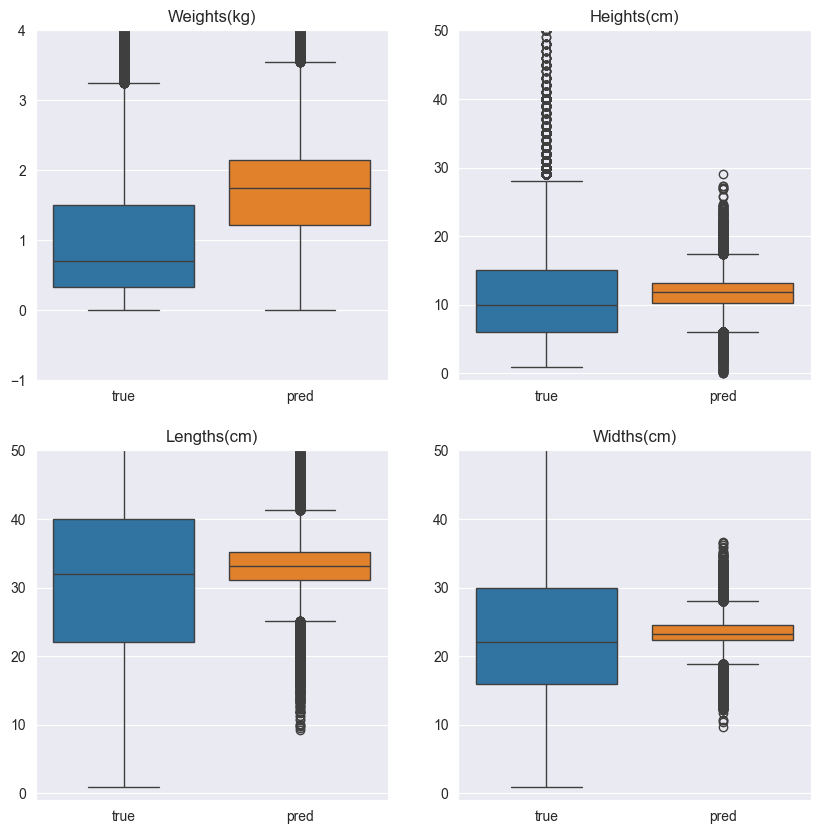

In [12]:
fg, axes = plt.subplots(2, 2)

fg.set_size_inches(10, 10)

sns.boxplot(data=[y_val[:, 0], lsa_lasso_preds[:, 0]], label="true",ax=axes[0, 0])
axes[0, 0].set_ylim(-1, 4)
axes[0, 0].title.set_text("Weights(kg)")
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(["true", "pred"])


sns.boxplot(data=[y_val[:, 1], lsa_lasso_preds[:, 1]], label="true",ax=axes[0, 1])
axes[0, 1].set_ylim(-1, 50)
axes[0, 1].title.set_text("Heights(cm)")
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(["true", "pred"])


sns.boxplot(data=[y_val[:, 2], lsa_lasso_preds[:, 2]], label="true",ax=axes[1, 0])
axes[1, 0].set_ylim(-1, 50)
axes[1, 0].title.set_text("Lengths(cm)")
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(["true", "pred"])


sns.boxplot(data=[y_val[:, 3], lsa_lasso_preds[:, 3]], label="true",ax=axes[1, 1])
axes[1, 1].set_ylim(-1, 50)
axes[1, 1].title.set_text("Widths(cm)")
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(["true", "pred"])



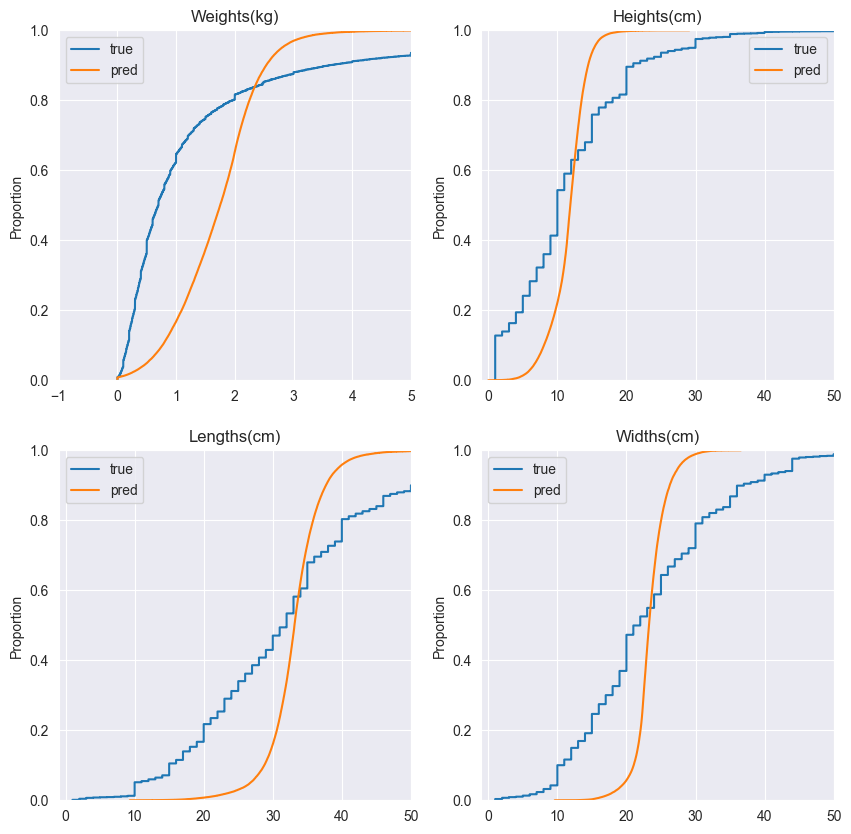

In [13]:
fg, axes = plt.subplots(2, 2)

fg.set_size_inches(10, 10)


sns.ecdfplot(y_val[:, 0],label="true",ax=axes[0, 0])
sns.ecdfplot(lsa_lasso_preds[:, 0],label="pred",ax=axes[0, 0])
axes[0, 0].set_xlim(-1, 5)
axes[0, 0].title.set_text("Weights(kg)")
axes[0, 0].legend()

sns.ecdfplot(y_val[:, 1],label="true",ax=axes[0, 1])
sns.ecdfplot(lsa_lasso_preds[:, 1],label="pred",ax=axes[0, 1])
axes[0, 1].set_xlim(-1, 50)
axes[0, 1].title.set_text("Heights(cm)")
axes[0, 1].legend()

sns.ecdfplot(y_val[:, 2],label="true",ax=axes[1, 0])
sns.ecdfplot(lsa_lasso_preds[:, 2],label="pred",ax=axes[1, 0])
axes[1, 0].set_xlim(-1, 50)
axes[1, 0].title.set_text("Lengths(cm)")
axes[1, 0].legend()

sns.ecdfplot(y_val[:, 3],label="true",ax=axes[1, 1])
sns.ecdfplot(lsa_lasso_preds[:, 3],label="pred",ax=axes[1, 1])
axes[1, 1].set_xlim(-1, 50)
axes[1, 1].title.set_text("Widths(cm)")
axes[1, 1].legend()


# BOE * TF-IDF

## fasttext

In [14]:
ft_corps = FastText(
    vector_size=300,
    window=5,
    min_count=5,
    workers=8
)

ft_corps.build_vocab(corpus_iterable=X_train)
ft_corps.train(
    corpus_iterable=X_train,
    total_examples=len(X_train),
    epochs=10
)

(72889727, 80613920)

In [15]:
X_train_ft = text_preprocessing.get_fasttext_embeddings(X_train, model=ft_corps, tfidf_vectorizer=tfidf_vectorizer)

Генерация эмбеддингов:   0%|          | 0/250326 [00:00<?, ?it/s]

In [16]:
X_val_ft = text_preprocessing.get_fasttext_embeddings(X_val, model=ft_corps, tfidf_vectorizer=tfidf_vectorizer)

Генерация эмбеддингов:   0%|          | 0/62582 [00:00<?, ?it/s]

In [17]:
param_grid_ft = {
    "alpha": [0.01, 0.1, 1.0, 10.0],
    "max_iter": [1500, 3000],
    "tol": [1e-4]
}

ft_lasso = GridSearchCV(
    Lasso(),
    param_grid_ft,
    cv=3,
    n_jobs=-1,
    verbose=2
)



In [18]:
ft_lasso.fit(X_train_ft, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


,estimator,Lasso()
,param_grid,"{'alpha': [0.01, 0.1, ...], 'max_iter': [1500, 3000], 'tol': [0.0001]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.01


In [19]:
ft_preds = ft_lasso.predict(X_val_ft)
ft_preds = np.maximum(0, ft_preds)
print(f'log mae macro: {metrics.logmae_macro(y_val, ft_preds)}')
print(f'log mae by cats: {metrics.logmae_bycat(y_val, ft_preds)}')

log mae macro: 0.44225496420876725
log mae by cats: [0.4906964  0.56397539 0.37035621 0.34399185]


## fasstext pretrained

In [20]:
import gensim.downloader as api

# 1. Загружаем модель один раз
print("Загрузка модели...")
fasttext_model = api.load('fasttext-wiki-news-subwords-300')


Загрузка модели...


In [21]:
train_embeddings = text_preprocessing.get_fasttext_embeddings(X_train, model=fasttext_model,
                                                              tfidf_vectorizer=tfidf_vectorizer)

Генерация эмбеддингов:   0%|          | 0/250326 [00:00<?, ?it/s]

In [22]:
val_embeddings = text_preprocessing.get_fasttext_embeddings(X_val, model=fasttext_model,
                                                            tfidf_vectorizer=tfidf_vectorizer)

Генерация эмбеддингов:   0%|          | 0/62582 [00:00<?, ?it/s]

In [23]:
param_grid_pretrainedft = {
    "alpha": [0.01, 0.1, 1.0],
    "max_iter": [1500, 3000],
    "tol": [1e-4]
}

pretrainedft_lasso = GridSearchCV(
    Lasso(),
    param_grid_pretrainedft,
    cv=3,
    n_jobs=-1,
    verbose=2
)

pretrainedft_lasso.fit(train_embeddings, y_train)
pretrainedft_preds = pretrainedft_lasso.predict(val_embeddings)
pretrainedft_preds = np.maximum(0, pretrainedft_preds)
print(f'log mae macro: {metrics.logmae_macro(y_val, pretrainedft_preds)}')
print(f'log mae macro: {metrics.logmae_bycat(y_val, pretrainedft_preds)}')

Fitting 3 folds for each of 6 candidates, totalling 18 fits
log mae macro: 0.47481781093376346
log mae macro: [0.56726905 0.60648827 0.35836064 0.36715328]


# DOC2VEC

In [24]:
class Doc2VecEmbedder:
    """Gensim Doc2Vec embedder"""

    def __init__(self, vector_size=200, min_count=2, epochs=30, workers=8):
        """
        vector_size: размерность вектора
        min_count: минимальная частота слова
        epochs: количество эпох обучения
        workers: количество потоков
        """
        self.vector_size = vector_size
        self.min_count = min_count
        self.epochs = epochs
        self.workers = workers
        self.model = None

    def _prepare_tagged_documents(self, texts):
        """Создание TaggedDocument objects"""
        tagged_docs = []
        for i, tokens in enumerate(tqdm(texts, desc="Preparing documents")):
            if isinstance(tokens, str):
                tokens = tokens.split()
            tagged_docs.append(TaggedDocument(words=tokens, tags=[i]))
        return tagged_docs

    def fit_transform(self, texts):
        # Инициализация модели
        texts = self._prepare_tagged_documents(texts)
        self.model = Doc2Vec(
            vector_size=self.vector_size,
            min_count=self.min_count,
            epochs=self.epochs,
            workers=self.workers,
            dm=1,  # PV-DM
            window=5,
            alpha=0.025,
            min_alpha=0.00025
        )

        self.model.build_vocab(texts)

        self.model.train(
            texts,
            total_examples=self.model.corpus_count,
            epochs=self.model.epochs
        )

        vectors = np.array([self.model.dv[i] for i in range(len(texts))])
        return vectors

    def transform(self, texts):

        vectors = []
        for text in texts:
            vector = self.model.infer_vector(text)
            vectors.append(vector)

        return np.array(vectors)

    def save(self, path):
        """Сохранение модели"""
        self.model.save(path)
        print(f"Модель сохранена: {path}")

    def load(self, path):
        """Загрузка модели"""
        self.model = Doc2Vec.load(path)
        print(f"Модель загружена: {path}")

In [26]:
doc2vec_embedder = Doc2VecEmbedder()
X_train_doc2vec = doc2vec_embedder.fit_transform(X_train)

Preparing documents:   0%|          | 0/250326 [00:00<?, ?it/s]

In [28]:
X_val_doc2vec = doc2vec_embedder.transform(X_val)

In [30]:
param_grid_doc2vec = {
    "alpha": [0.01, 0.1, 1.0],
    "max_iter": [1500, 3000],
    "tol": [1e-4]
}

doc2vec_lasso = GridSearchCV(
    Lasso(),
    param_grid_doc2vec,
    cv=3,
    n_jobs=-1,
    verbose=2
)

doc2vec_lasso.fit(X_train_doc2vec, y_train)
doc2vec_preds = doc2vec_lasso.predict(X_val_doc2vec)
doc2vec_preds = np.maximum(0, doc2vec_preds)
print(f'log mae macro: {metrics.logmae_macro(y_val, doc2vec_preds)}')
print(f'log mae macro: {metrics.logmae_bycat(y_val, doc2vec_preds)}')

Fitting 3 folds for each of 6 candidates, totalling 18 fits
log mae macro: 0.47481781134734014
log mae macro: [0.56726904 0.60648825 0.35836066 0.36715329]
